In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(anndata))
library(ggplot2)
library(ggridges)
library(pheatmap)
library(RColorBrewer)
suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(InteractionSet))
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand


Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
corder <- read.table("../04.clustering/order.subclass.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% dplyr::select(V1) %>% unlist %>% as.character

cols <- read.csv("../../ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

tmp <- read.csv("../04.clustering/subclass_corrected.color.csv", row.names = 1)
ccol2 <- tmp$color
names(ccol2) <- tmp$MiniAtlas

In [3]:
rmeta <- read.csv("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", sep = '\t')

In [4]:
gaba <- rmeta %>% filter(class == "GABA") %>% select(subclass_corrected) %>% unlist %>% as.character %>% unique
glut <- rmeta %>% filter(class == "Glut") %>% select(subclass_corrected) %>% unlist %>% as.character %>% unique
nonn <- rmeta %>% filter(class == "NonN") %>% select(subclass_corrected) %>% unlist %>% as.character %>% unique

In [5]:
pair_df2 <- read.table("../06.integration/snm3c_DPT_RNA_250601.pred_subclass_match.txt", header = T)

In [6]:
snm3meta <- read.table("../../ref/hba_snm3c/table-S4-cell-type-taxonomy.tsv", sep = '\t', row.names = 1, header = T)
snm3meta$color <- NA
snm3meta[snm3meta$CellClass == 'Non-neuronal Cells', ]$color <- '#da8dc9'
snm3meta[snm3meta$CellClass == 'Telencephalic excitatory neurons', ]$color <- '#cb6751'
snm3meta[snm3meta$CellClass == 'Inhibitory/non-telencephalic neurons', ]$color <- '#3191ed'

In [7]:
tmp <- snm3meta %>% mutate(CellClass = factor(CellClass, levels = c('Non-neuronal Cells', 'Telencephalic excitatory neurons', 'Inhibitory/non-telencephalic neurons'))) %>%
arrange(CellClass) %>% select(MajorType, color) %>% distinct

sorder <- tmp$MajorType
ccoln <- tmp$color

sorder <- gsub("-", "_", sorder)
sorder <- gsub("\\/", "", sorder)
sorder <- gsub("Amy_Exc", "Amy", sorder)
sorder <- gsub("Chd7", "CHD7", sorder)
sorder <- gsub("SubCtx_Cplx", "SubCtx", sorder)
sorder <- gsub("Lamp5_Lhx6", "Lamp5_LHX6", sorder)

names(ccoln) <- sorder

## Inspect all longrange contacts

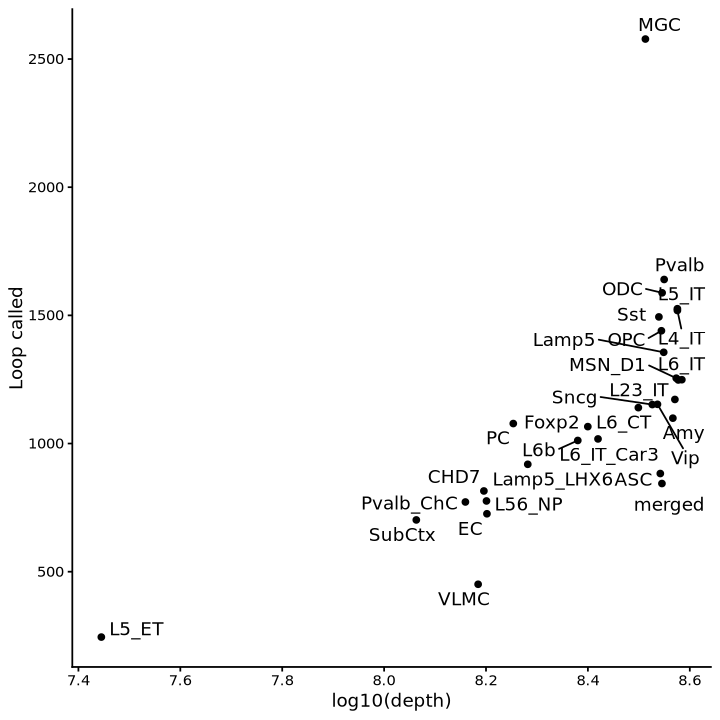

In [406]:
flist <- list()
for (file in list.files("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/peakachu/FitHiC/fithic_filter/q10-10")){
    fname <- gsub(".loops.bedpe", "", file)
    flist[[fname]] <- read.table(paste0("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/peakachu/FitHiC/fithic_filter/q10-7/", file)) %>%
    mutate(distance = abs(V5 - V3)) %>% ### 10kb bins 
    setNames(c("c1", "s1", "e1", "c2", "s2", "e2", "prob", "raw_signal", 'distance')) %>%
    mutate(celltype = fname)
}

options(repr.plot.width = 6, repr.plot.height = 6)
loopcount <- as.data.frame(lapply(flist, nrow)) %>% t %>% as.data.frame
merge(clist, loopcount, by = 0) %>%
ggplot(aes(x = log10(depth), y = V1, label = celltype)) + 
geom_point() + 
ggrepel::geom_text_repel() + ylab("Loop called") +  
theme_classic()

In [409]:
### Focused on only long-range interactions
flist2 <- lapply(flist, function(x) x %>% filter(distance >= 5000000))

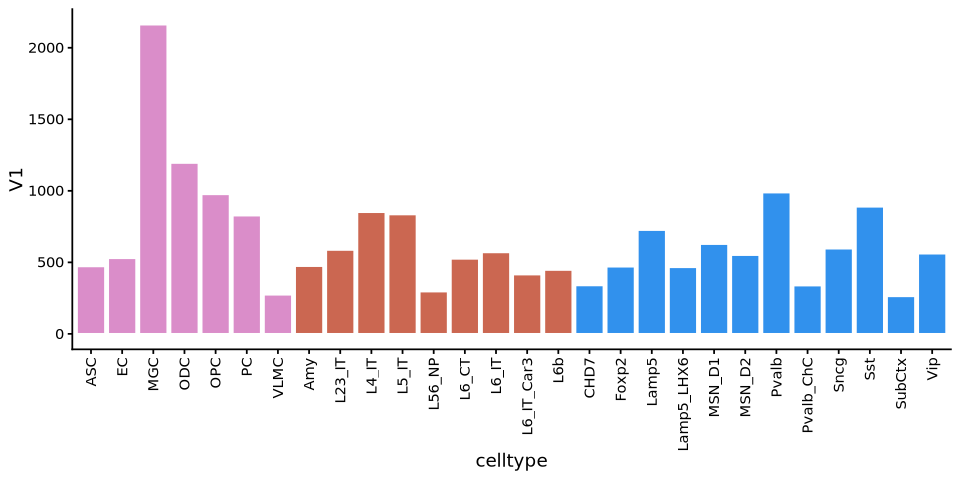

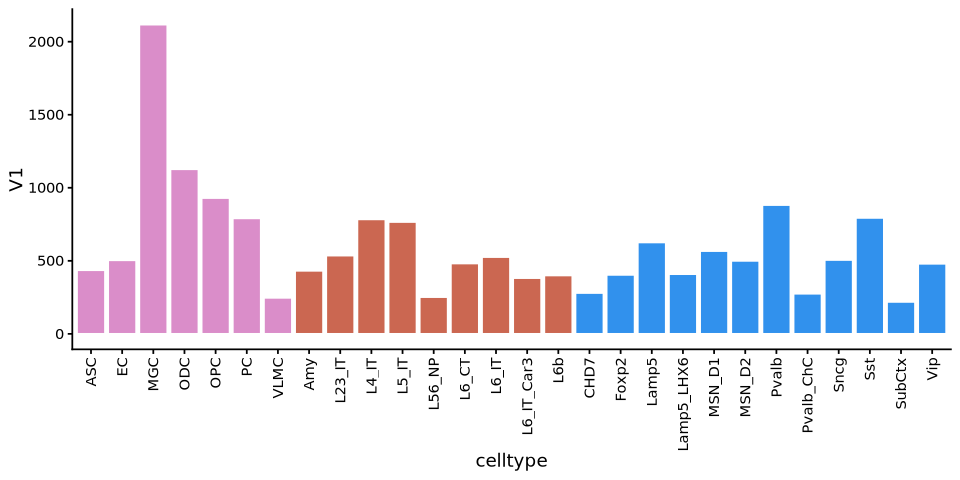

In [677]:
### Number of interactions?
loopcount <- as.data.frame(lapply(flist2, function(x) x %>% nrow)) %>% t %>% as.data.frame

options(repr.plot.width = 8, repr.plot.height = 4)
loopcount %>% tibble::rownames_to_column("celltype") %>% filter(celltype != "merged") %>%
mutate(celltype = factor(celltype, levels = sorder)) %>%
ggplot(aes(x = celltype, y = V1, fill = celltype)) + 
geom_col(color = "white") + 
theme_classic() + scale_fill_manual(values = ccoln) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
NoLegend()
                                  
loopcount <- as.data.frame(lapply(flist2, function(x) x %>% filter(c1 != 'chr19') %>% nrow)) %>% t %>% as.data.frame
loopcount %>% tibble::rownames_to_column("celltype") %>% filter(celltype != "merged") %>%
mutate(celltype = factor(celltype, levels = sorder)) %>%
ggplot(aes(x = celltype, y = V1, fill = celltype)) + 
geom_col(color = "white") + 
theme_classic() + scale_fill_manual(values = ccoln) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
NoLegend()

### Number doesnt show difference between neuronal / nonneuronal

In [412]:
flist3 <- list()
for (f in names(flist2)){
    qloop <- data.table::fread(paste0("/projects//ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/peakachu/FitHiC/", f, "/FitHiC.spline_pass1.res100000.significances.bedpe")) %>%
    setNames(c("c1", "s1", "e1", "c2", "s2", "e2", "q-value", "contactCount", "ExpCC", "strand"))
    flist3[[f]] <- merge(qloop, flist2[[f]], by = c("c1", "s1", "e1", "c2", "s2", "e2"))
}

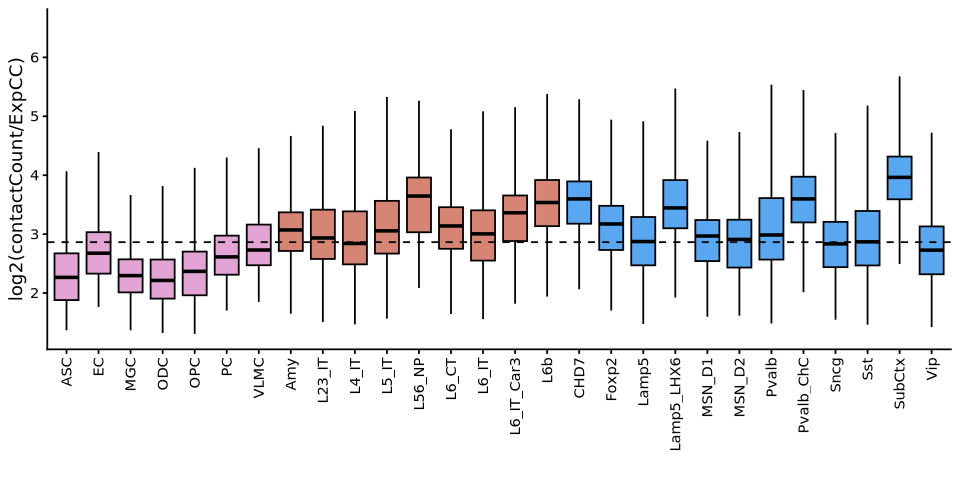

In [414]:
t1 <- do.call(rbind, flist3) %>% mutate(avg = mean(log2(contactCount/ExpCC))) %>%
filter(celltype != "merged") %>%
mutate(celltype = factor(celltype, levels = sorder)) %>%
ggplot(aes(x = celltype, y = log2(contactCount/ExpCC), fill = celltype)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
geom_hline(aes(yintercept = unique(avg)), linetype = 2) + 
theme_classic() + scale_fill_manual(values = ccoln) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
xlab("") + NoLegend()

options(repr.plot.width = 8, repr.plot.height = 4)
t1

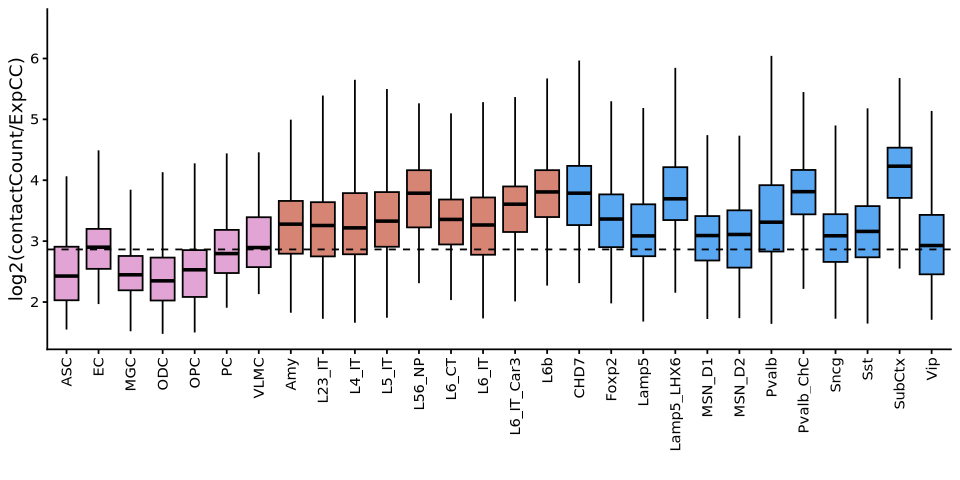

In [415]:
### increase confidence level using stricter p cutoff
do.call(rbind, flist3) %>% mutate(avg = mean(log2(contactCount/ExpCC))) %>%
filter(celltype != "merged", `q-value` <= 10^-10) %>%
mutate(celltype = factor(celltype, levels = sorder)) %>%
ggplot(aes(x = celltype, y = log2(contactCount/ExpCC), fill = celltype)) + 
geom_boxplot(color="black", alpha=0.8, coef = 2, outlier.shape = NA, 
             position = position_dodge(width = 0.9)) + 
geom_hline(aes(yintercept = unique(avg)), linetype = 2) + 
theme_classic() + scale_fill_manual(values = ccoln) + 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
xlab("") + NoLegend()

### How specific are these interactions

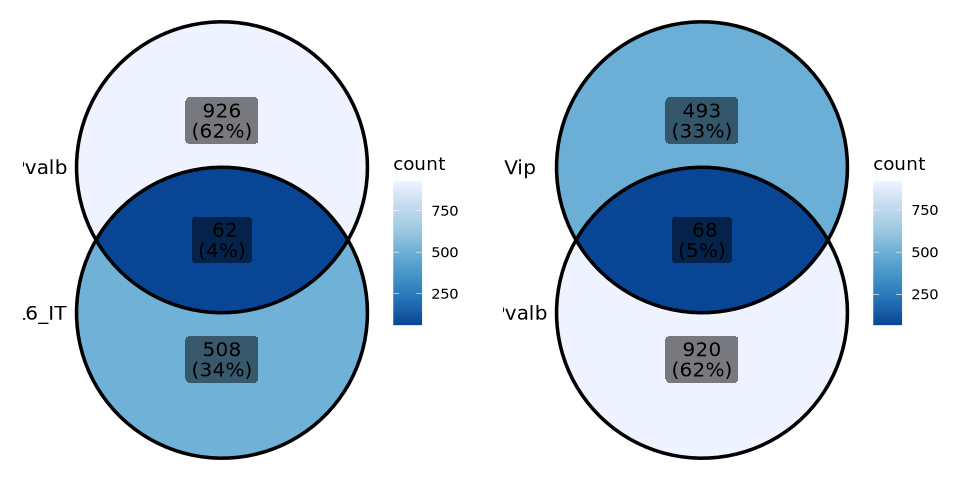

In [488]:
library(ggVennDiagram)
qqlist <- lapply(flist2, function(x) x %>% mutate(pair = paste0(c1, ":", s1, "-", e1, "_", c2, ":", s2, "-", e2)) %>% select(pair) %>% unlist %>% as.character %>% unique)

qorder <- c('L6_IT', 'Pvalb')
t1 <- ggVennDiagram(qqlist[qorder]) + scale_fill_distiller()     

qorder <- c('Pvalb', 'Vip')
t2 <- ggVennDiagram(qqlist[qorder]) + scale_fill_distiller()   

options(repr.plot.width = 8, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

## Compare long-range interaction APA 

In [237]:
### calculated using peakachu_fithic2_q10-7.5Mb
apalist <- list()
for (file in list.files("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/peakachu/APA")){
    for (file2 in list.files(paste0("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/peakachu/APA/", file))){
        qfile <- paste0("/projects/ps-renlab2/y2xie/projects/BICAN/ref/hba_snm3c/peakachu/APA/", file, "/", file2, "/10000/gw/measures.txt")
        if (file.exists(qfile)){
            p2ll <- read.table(qfile, sep = '\t')[4,2]
            apalist[[paste0(file, ":", file2)]] <- data.frame(P2LL = p2ll, celltype1 = file, celltype2 = file2)
        }
    }
}
apalist <- do.call(rbind, apalist)

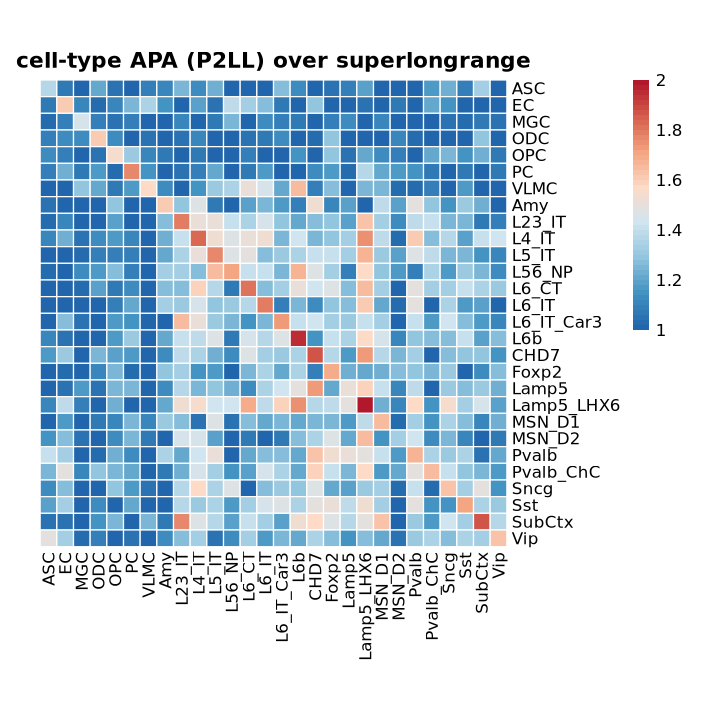

In [371]:
options(repr.plot.width = 6, repr.plot.height = 6)
qmtx <- apalist %>% 
filter(!(celltype2 %in% c("merged", "Lamp5_Lhx6", "MSN", "L5_ET")), !(celltype1 %in% c("merged", "Lamp5_Lhx6", "MSN", "L5_ET"))) %>%
reshape2::dcast(celltype1 ~ celltype2, value.var = "P2LL") %>%
tibble::column_to_rownames("celltype1") 

qsorder <- intersect(sorder, rownames(qmtx))
fig1 <- qmtx[qsorder, qsorder] %>%
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(1, 2, 0.02), border_color = "white", 
         cellheight = 10, cellwidth = 10, angle_col = 90, main = c("cell-type APA (P2LL) over superlongrange"),
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50)))

### Pretty specfic!
ggsave(fig1, filename = "../Figure/superlongrange_100kb_loops_APA.pdf", dpi = 300, height = 6, width = 6)

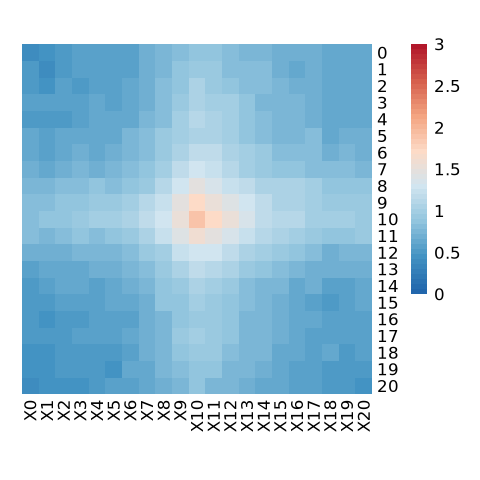

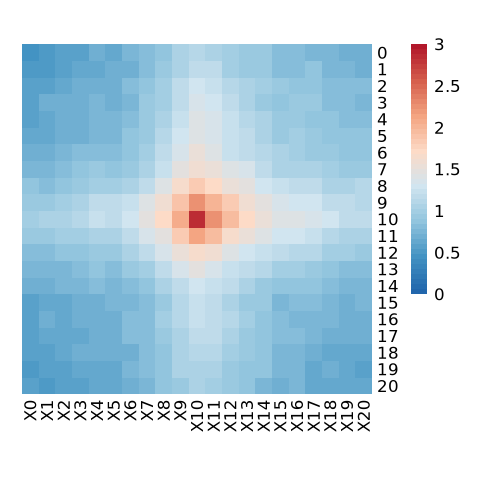

In [260]:
flist <- list()
for (file in list.files(pattern = ".pileup.csv")){
    fname1 <- gsub("^(.+?)_over_.*$", "\\1", file)
    fname2 <- gsub("^.*_SLR_([^\\.]+)\\.pileup\\.csv$", "\\1", file)
    flist[[paste0(fname1, ":", fname2)]] <- read.csv(file, row.names = 1)
}

options(repr.plot.width = 4, repr.plot.height = 4)
t1 <- log2(flist[[2]]) %>%
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(0, 3, 0.06),
         border_color = NA, 
         cellheight = 10, cellwidth = 10, angle_col = 90, ,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50)))

t2 <- log2(flist[[4]]) %>%
pheatmap(cluster_rows = F, cluster_cols = F, breaks = seq(0, 3, 0.06),
         border_color = NA, 
         cellheight = 10, cellwidth = 10, angle_col = 90, ,
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50)))


## histone modification at longrange interaction anchors

In [83]:
reciprocal_overlaps <- function(query, subject, f = 0.3, F = 0) {
    hits <- findOverlaps(query, subject, ignore.strand = TRUE)
    if (length(hits) == 0L) return(hits)
    q <- queryHits(hits); s <- subjectHits(hits)
    ovl <- pintersect(ranges(query)[q], ranges(subject)[s])
    ovl_w <- width(ovl)
    keep <- (ovl_w >= f * width(query)[q]) & (ovl_w >= F * width(subject)[s])
    hits[keep]
}

In [224]:
ac10 <- read.csv("../05.peaks_calling/MiniAtlas_H3K27ac.100kb_251002.subclass_corrected.cpm.csv", row.names = 1)
me10 <- read.csv("../05.peaks_calling/MiniAtlas_H3K27me3.100kb_251002.subclass_corrected.cpm.csv", row.names = 1)
colnames(ac10) <- gsub("\\.", "-", colnames(ac10))
colnames(me10) <- gsub("\\.", "-", colnames(me10))

### anchors analysis: need to overlap 30% peaks.
### if a peak overlap with peaks from two marks, determine using: (1) mark signal logFC > 1; (2) mark signal over 90% quantile
olist1 <- olist2 <- ovlist <- list()
for (i in 1:nrow(pair_df2)){
    ct1 <- pair_df2[i, "MiniAtlas"]
    ct2 <- pair_df2[i, "snm3c"]
    ct2 <- gsub("-", "_", ct2)
    ct2 <- gsub("\\/", "", ct2)
    if (!(ct2 %in% c("L5_ET", 'MSN_D2')) & !is.na(ct2)){
        if (ct2 == "Chd7"){ct2 <- "CHD7"}
        if (ct2 == "Lamp5_Lhx6"){ct2 <- "Lamp5_LHX6"}

        ### use strict filter!!
        
        loop <- flist2[[ct2]]
        
        l1 <- loop[,1:3] %>% distinct
        l2 <- loop[,4:6] %>% distinct %>% setNames(colnames(l1))
        loop_anchors <- rbind(l1, l2) %>% distinct
        looprange <- GRanges(loop_anchors[,1], ranges = IRanges(as.numeric(loop_anchors[,2]), as.numeric(loop_anchors[,3])))
        
        ### H3K27me3
        p1 <- read.table(paste0("../05.peaks_calling/250601/parseK27me3/", ct1, ".naivePeakList.broadPeak.gz")) %>%
        dplyr::select(V1, V2, V3) %>% distinct
        prange1 <- GRanges(p1[,1], ranges = IRanges(as.integer(p1[,2]), as.integer(p1[,3])))
        flp <- reciprocal_overlaps(prange1, looprange, f = 0.3, F = 0)
        
        tmp <- cbind(p1[queryHits(flp),], loop_anchors[subjectHits(flp),]) %>% 
        setNames(c("pchr", "pstart", "pend", "lchr", "lstart", "lend")) %>%
        mutate(range1 = paste0(pchr, ":", pstart, "-", pend), range2 = paste0(lchr, ":", lstart, "-", lend)) %>%
        mutate(celltype = ct1, target = "H3K27me3")
        
        accutoff <- quantile(ac10[, ct1], prob = 0.5)
        mecutoff <- quantile(me10[, ct1], prob = 0.5)

        tmp$ac_signal <- ac10[tmp$range2, ct1] + pi
        tmp$me3_signal <- me10[tmp$range2, ct1] + pi
        tmp$ac_vs_me <- log2(tmp$ac_signal/tmp$me3_signal)
        olist1[[i]] <- tmp %>% 
        mutate(type = ifelse((ac_vs_me >= 1), "conflict", "unknown")) %>%
        mutate(type = ifelse((ac_vs_me <= -1 & me3_signal >= mecutoff), "confident", type))

        ### H3K27ac
        p2 <- read.table(paste0("../05.peaks_calling/250601/parseK27ac/", ct1, ".naivePeakList.narrowPeak.gz")) %>%
        dplyr::select(V1, V2, V3) %>% distinct
        prange2 <- GRanges(p2[,1], ranges = IRanges(as.integer(p2[,2]), as.integer(p2[,3])))
        flp <- reciprocal_overlaps(prange2, looprange, f = 0.3, F = 0)
        
        tmp <- cbind(p2[queryHits(flp),], loop_anchors[subjectHits(flp),]) %>% 
        setNames(c("pchr", "pstart", "pend", "lchr", "lstart", "lend")) %>%
        mutate(range1 = paste0(pchr, ":", pstart, "-", pend), range2 = paste0(lchr, ":", lstart, "-", lend)) %>%
        mutate(celltype = ct1, target = "H3K27ac")
        tmp$ac_signal <- ac10[tmp$range2, ct1] + pi
        tmp$me3_signal <- me10[tmp$range2, ct1] + pi
        tmp$ac_vs_me <- log2(tmp$ac_signal/tmp$me3_signal)
        olist2[[i]] <- tmp %>% 
        mutate(type = ifelse((ac_vs_me <= -1), "conflict", "unknown")) %>%
        mutate(type = ifelse((ac_vs_me >= 1 & ac_signal >= accutoff), "confident", type))

        tmp <- olist1[[i]]
        tmp2 <- olist2[[i]]
        urange1 <- setdiff(tmp$range2, tmp2$range2) ### unique
        urange2 <- setdiff(tmp2$range2, tmp$range2) ### unique
        srange <- intersect(tmp$range2, tmp2$range2) ### shared
        qpair <- rbind(tmp[tmp$range2 %in% urange1,], tmp2[tmp2$range2 %in% urange2,]) ### unique
        
        ### 100kb is too big and will overlap multiple peaks?
        if (length(srange) > 0){
            qpair2 <- tmp[tmp$range2 %in% srange,] %>%
            mutate(target = ifelse(ac_vs_me >= 1 & ac_signal >= accutoff, "H3K27ac", target),
                   type = ifelse(ac_vs_me >= 1 & ac_signal >= accutoff, "mix_confident", "unknown")) %>%
            mutate(target = ifelse(ac_vs_me <= -1 & me3_signal >= mecutoff, "H3K27me3", target),
                   type = ifelse(ac_vs_me <= -1 & me3_signal >= mecutoff, "mix_confident", type))
            ovlist[[i]] <- rbind(qpair, qpair2)
        }else{
            ovlist[[i]] <- qpair
        }
    }
}

ovlist <- do.call(rbind, ovlist)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chr21
  - in 'y': chr3, chr8, chrX
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


In [38]:
### write anchors for annoPeaks
system("mkdir superlongrange_anchors")
qend <- ovlist %>% filter(type == "confident", target == "H3K27me3") %>% 
select(lchr,lstart,lend) %>% distinct 
write.table(qend, "superlongrange_anchors/H3K27me3_anchors.bed", sep = "\t", quote = F, row.names = F, col.names = F)

qend <- ovlist %>% filter(type == "confident", target == "H3K27ac") %>% 
select(lchr,lstart,lend) %>% distinct
write.table(qend, "superlongrange_anchors/H3K27ac_anchors.bed", sep = "\t", quote = F, row.names = F, col.names = F)

In [49]:
flist <- list()
for (file in list.files("superlongrange_anchors/", pattern = ".anno$")){
    mark = gsub("([^_]+)_anchors.anno", "\\1", file)
    flist[[mark]] <- read.csv(paste0("superlongrange_anchors/", file), sep = "\t", header = T) %>%
    mutate(target = mark)
}

In [53]:
qlevel <- c('CpG', 'exon ', 'intron ', 'Intergenic', 'promoter-TSS ', '5\' UTR ', '3\' UTR ', 'TTS ', 'non-coding ', 'SINE', 'LINE', 'LTR', 'Other repeats', 'Simple_repeat')

qfile <- grep("H3K27ac", names(flist))
t1 <- do.call(rbind, lapply(flist[qfile], function(x) sum_detailed_anno(x) %>% filter(Var1 %in% qlevel))) %>%
group_by(Var1) %>% summarise(tFreq = sum(Freq)) %>% ungroup %>%
mutate(Var1 = factor(Var1, levels = qlevel)) %>%
ggplot(aes(x = "", y = tFreq, fill = Var1)) +
geom_bar(width = 1, stat = "identity", color = "white") +
coord_polar(theta = "y") + 
scale_fill_manual(values = colfunc(14)) + 
theme_void()

qfile <- grep("H3K27me3", names(flist))
t2 <- do.call(rbind, lapply(flist[qfile], function(x) sum_detailed_anno(x) %>% filter(Var1 %in% qlevel))) %>%
group_by(Var1) %>% summarise(tFreq = sum(Freq)) %>%
mutate(Var1 = factor(Var1, levels = qlevel)) %>%
ggplot(aes(x = "", y = tFreq, fill = Var1)) +
geom_bar(width = 1, stat = "identity", color = "white") +
coord_polar(theta = "y") + 
scale_fill_manual(values = colfunc(14)) + 
theme_void()

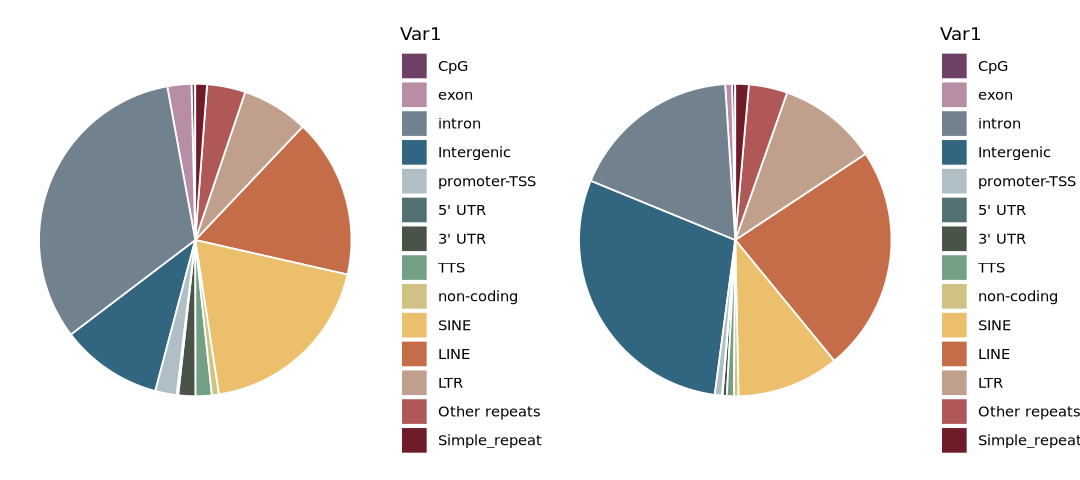

In [54]:
options(repr.plot.width = 9, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

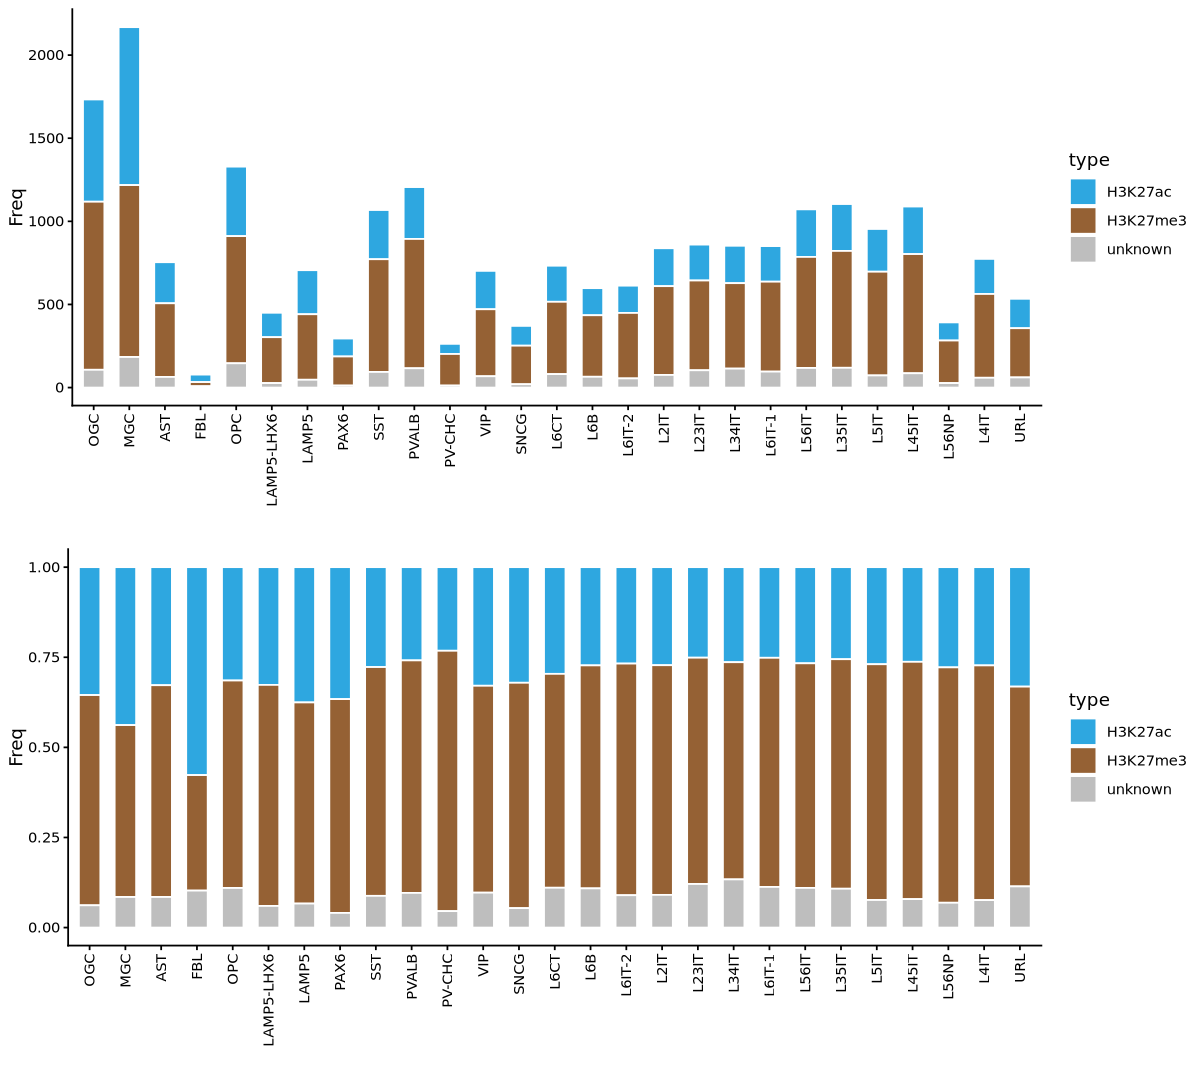

In [228]:
### Unique loops anchors
badcelltype <- c("ENDO", "IMMUNE", "L5ET", "SST-CHODL")

t1 <- ovlist[,c("range2", "target", "type", "celltype")] %>%
distinct %>% filter(!(celltype %in% badcelltype)) %>%
mutate(type = ifelse(type %in% c("conflict", "unknown"), "unknown", type)) %>%
mutate(type = ifelse(type %in% c("confident", "mix_confident"), "confident", type)) %>%
mutate(type = ifelse(type == "confident", target, "unknown")) %>%
dplyr::select(type, celltype) %>%
table %>% as.data.frame %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = type)) +
geom_col(width = 0.6, position = "stack", color = "white") + 
theme_classic() + xlab("") + scale_fill_manual(values = c("#2EA7E0", "#956134", "grey")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

t2 <- ovlist[,c("range2", "target", "type", "celltype")] %>%
distinct %>% filter(!(celltype %in% badcelltype)) %>%
mutate(type = ifelse(type %in% c("conflict", "unknown"), "unknown", type)) %>%
mutate(type = ifelse(type %in% c("confident", "mix_confident"), "confident", type)) %>%
mutate(type = ifelse(type == "confident", target, "unknown")) %>%
dplyr::select(type, celltype) %>%
table %>% as.data.frame %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = type)) +
geom_col(width = 0.6, position = "fill", color = "white") + 
theme_classic() + xlab("") + scale_fill_manual(values = c("#2EA7E0", "#956134", "grey")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

fig1 <- cowplot::plot_grid(t1, t2, nrow = 2)

options(repr.plot.width = 10, repr.plot.height = 9)
fig1
### This is the loops that overlap with histone modification!!!

In [289]:
### For conflict pairs: need to handle with signal contrast and also output all the interactions!!
### criteria: either one 
qovlist <- ovlist %>%
mutate(type = ifelse(type %in% c("conflict", "unknown"), "unknown", type)) %>%
mutate(type = ifelse(type %in% c("confident", "mix_confident"), "confident", type)) %>%
mutate(type = ifelse(type == "confident", target, "unknown")) 

olist4 <- list()
for (i in 1:nrow(pair_df2)){
    ct1 <- pair_df2[i, "MiniAtlas"]
    ct2 <- pair_df2[i, "snm3c"]
    ct2 <- gsub("-", "_", ct2)
    ct2 <- gsub("\\/", "", ct2)
    if (!(ct2 %in% c("L5_ET", 'MSN_D2')) & !is.na(ct2)){
        if (ct2 == "Chd7"){ct2 <- "CHD7"}
        if (ct2 == "Lamp5_Lhx6"){ct2 <- "Lamp5_LHX6"}
        loop <- flist2[[ct2]]
        loop <- loop %>% mutate(range1 = paste0(c1, ":", s1, "-", e1), range2 = paste0(c2, ":", s2, "-", e2)) %>%
        dplyr::select(range1, range2)
        qlist <- qovlist %>% filter(celltype == ct1) %>% dplyr::select(range2, type) %>% distinct ### is this correct?
        
        t1 <- merge(loop, qlist, by.x = "range1", by.y = "range2", all.x = T) ### left anchors
        t2 <- merge(loop, qlist, by = "range2", all.x = T) ### right anchors
        
        olist4[[ct1]] <- merge(t1, t2, by = c("range1", "range2"), all = T) %>%
        mutate(type.x = ifelse(is.na(type.x), "unknown", type.x)) %>% # mutate(celltype = ct1) 
        mutate(type.y = ifelse(is.na(type.y), "unknown", type.y)) %>% 
        mutate(ltype = ifelse(type.x == "H3K27ac" & type.y != "H3K27me3", "H3K27ac", "unknown")) %>%
        mutate(ltype = ifelse(type.x == "H3K27me3" & type.y != "H3K27ac", "H3K27me3", ltype)) %>%
        mutate(ltype = ifelse(type.x != type.y & type.y != "unknown" & type.x != "unknown", "mix", ltype)) %>%
        mutate(celltype = ct1)
    }
}

olist4 <- do.call(rbind, olist4)

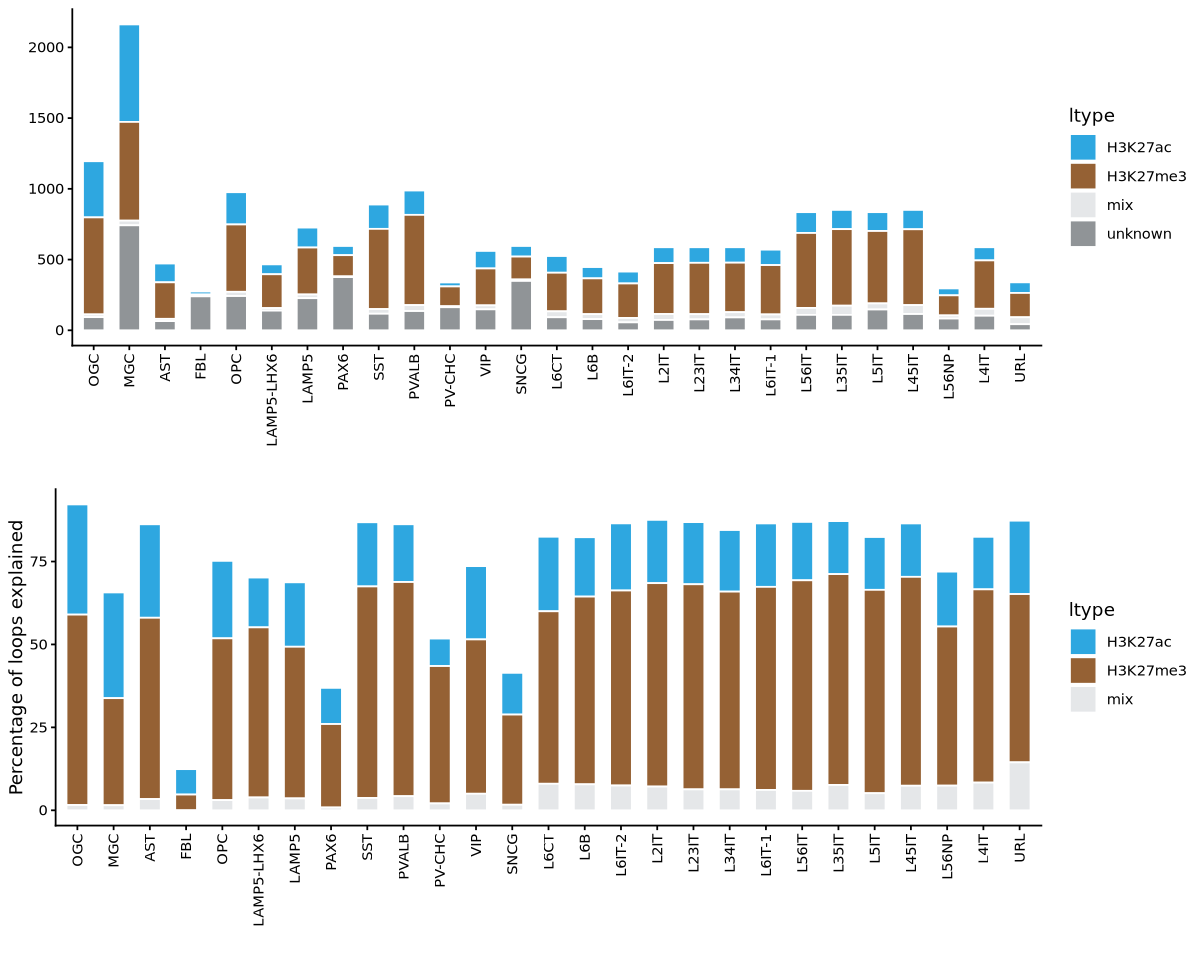

In [291]:
### Unique loops
t1 <- olist4 %>% distinct %>% filter(!(celltype %in% badcelltype)) %>%
dplyr::select(ltype, celltype) %>% table %>% as.data.frame %>% 
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = Freq, fill = ltype)) +
geom_col(width = 0.6, position = "stack", color = "white") + 
theme_classic() + xlab("") + ylab("") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9", "#909497")) +  
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

t2 <- olist4 %>% distinct %>%
dplyr::select(ltype, celltype) %>% table %>% as.data.frame %>% 
group_by(celltype) %>% mutate(ratio = Freq/sum(Freq)) %>% ungroup %>%
filter(ltype != "unknown") %>% filter(!(celltype %in% badcelltype)) %>%
mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = 100*ratio, fill = ltype)) +
geom_col(width = 0.6, position = "stack", color = "white") + 
theme_classic() + xlab("") + ylab("Percentage of loops explained") + 
scale_fill_manual(values = c("#2EA7E0", "#956134", "#E5E7E9")) +  #, "#909497"
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

fig2 <- cowplot::plot_grid(t1, t2, nrow = 2)

options(repr.plot.width = 10, repr.plot.height = 8)
fig2

## Compare genes at loops anchors

In [15]:
### Repressive SLR overlap genes first
adf <- olist4 %>% filter(ltype == "H3K27ac") %>% group_by(celltype) %>% group_split()
rdf <- olist4 %>% filter(ltype == "H3K27me3") %>% group_by(celltype) %>% group_split()
hg38 <- read.table("/projects//ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.v43.10X.bed")
generange <- GRanges(hg38[,1], ranges = IRanges(as.integer(hg38[,2]), as.integer(hg38[,3])), gene = hg38$V6)

qovlp <- list()
for (tmp in rdf){
    ct <- unique(tmp$celltype)
    qdf <- stringr::str_split_fixed(unique(c(tmp$range1, tmp$range2)), pattern = "[:-]", n = 3)
    lrange <- GRanges(qdf[,1], ranges = IRanges(as.integer(qdf[,2]), as.integer(qdf[,3])))
    qovlp[[ct]] <- as.data.frame(findOverlapPairs(lrange, generange, type = "any"))
}

In [373]:
glist <- glist2 <- list()
for (f in names(qovlp)){ 
    tmp <- qovlp[[f]]
    qgene <- tmp$second.gene %>% unique
    qtable <- clusterProfiler::enrichGO(gene = qgene,
                OrgDb = org.Hs.eg.db::org.Hs.eg.db,
                keyType = 'SYMBOL',
                ont = "BP", # biological process
                pAdjustMethod = "BH", 
                pvalueCutoff = 0.05, 
                qvalueCutoff = 0.05, 
                readable = TRUE)
    glist[[f]] <- qtable@result %>% mutate(celltype = f) 
    qtable2 <- clusterProfiler::simplify(qtable, cutoff=0.7, by="p.adjust", select_fun=min)
    glist2[[f]] <- qtable2@result %>% mutate(celltype = f)
}

do.call(rbind, glist2) %>% dplyr::select(celltype) %>% table

celltype
       AST       ENDO        FBL     IMMUNE      L23IT       L2IT      L34IT 
        32         23         10         18        104        102        110 
     L35IT      L45IT       L4IT      L56IT      L56NP       L5IT        L6B 
       106        120        101        107         74        115         89 
      L6CT     L6IT-1     L6IT-2      LAMP5 LAMP5-LHX6        MGC        OGC 
        73         77         84         92         99         46         36 
       OPC       PAX6     PV-CHC      PVALB       SNCG        SST  SST-CHODL 
         4         77         78         90        103        103        123 
       URL        VIP 
        76         68 

[1] 24

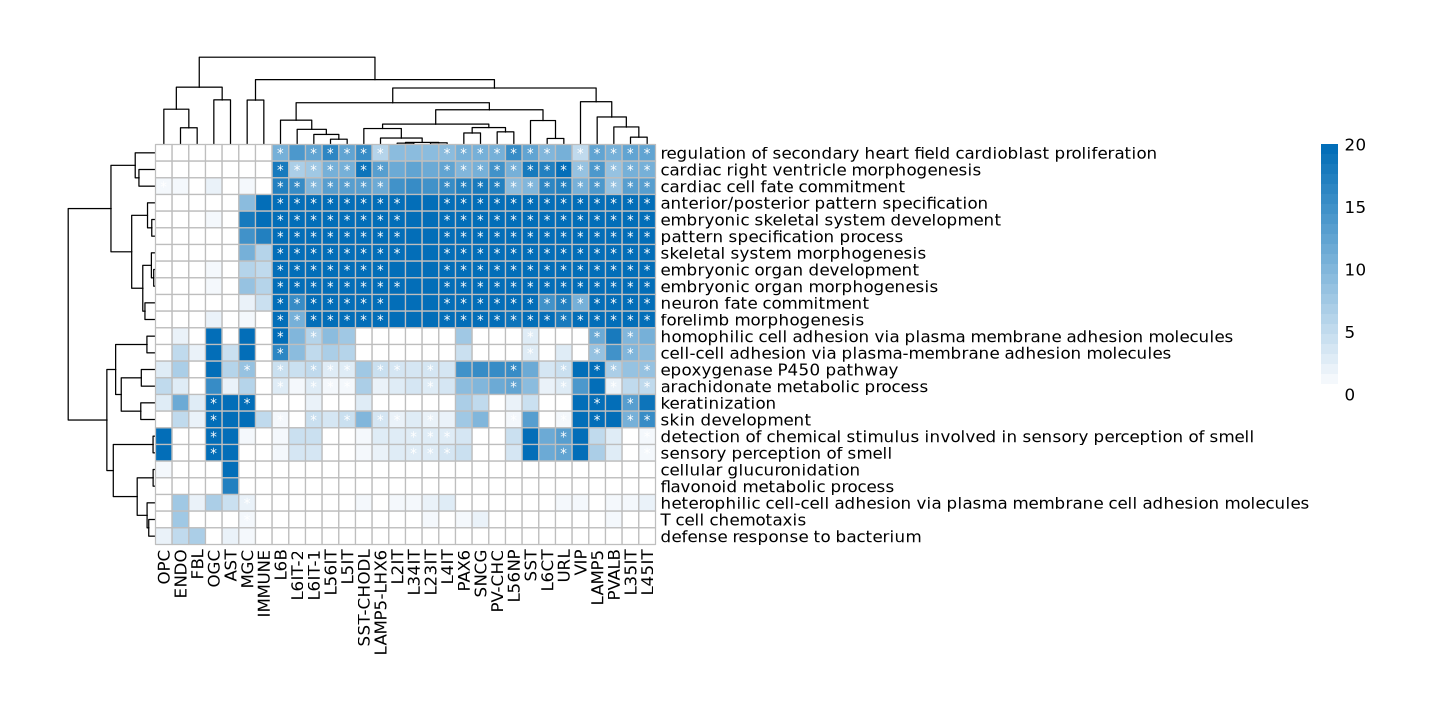

In [385]:
qterm1 <- do.call(rbind, glist2) %>%
filter(p.adjust < 0.05, Count >= 5) %>%
group_by(celltype) %>%
slice_max(order_by = -log10(p.adjust)*FoldEnrichment, n = 3) %>%
ungroup %>% dplyr::select(Description) %>% unlist %>% unique

length(qterm1)

tmp <- do.call(rbind, glist) %>%
reshape2::dcast(Description ~ celltype, value.var = "p.adjust", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1

ttp1 <- -log2(tmp[qterm1, intersect(corder, colnames(tmp))])
ttp1[ttp1 > 20] <- 20

lmat1 <- tmp
lmat1 <- ifelse(lmat1 < 0.01, "*", "")

options(repr.plot.width = 12, repr.plot.height = 6)
fig1 <- ttp1 %>% 
pheatmap(cluster_cols = T, cluster_rows = T, 
         border_color = "gray", show_rownames = T,
         angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat1[rownames(ttp1), ], number_color = "white",
         color = colorRampPalette(c("white", "#036EB8"))(25))

## Repressive interactions: does the gene expression at these loci happen during developments

In [10]:
### read developmental gene expression
drpkm <- read.table("../../ref/Keefe2025Nature/subcluster_identity_age.rpkm", header = T, row.names = 1, check.names = F)
rpkm <- read.table("../04.clustering/02.RNA/MiniAtlas_RNA_merged_dual_filt_clean_250724.subclass.rpkm.txt", header = T, row.names = 1, check.names = F)

In [73]:
nrow(drpkm)
nrow(rpkm)
intersect(rownames(rpkm), rownames(drpkm)) %>% length

[1] 27574

[1] 38369

[1] 19175

In [114]:
ref <- readRDS("../../ref/Keefe2025Nature/cortex_midgestation_final_1.rds")
ref

An object of class Seurat 
27581 features across 97540 samples within 1 assay 
Active assay: RNA (27581 features, 2000 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: pca, umap, harmony

In [118]:
cell1 <- list()
for (f in unique(ref$group)){
    cell1[[f]] <- rownames(ref@meta.data[ref$group == f,])
    if(length(cell1[[f]]) > 2000){cell1[[f]] <- sample(cell1[[f]], size = 2000, replace = F)}
}
ref <- subset(ref, cells = unlist(cell1))
qry <- qs::qread("../06.integration/MiniAtlas_RNA_merged_dual_filt_clean_250520_subset_subclass_for_int.qs")

In [119]:
### Run Integration: Seurat v5
obj <- merge(qry, ref)
obj <- NormalizeData(obj)
obj <- FindVariableFeatures(obj)
obj <- ScaleData(obj, verbose = FALSE)
obj <- RunPCA(obj, npcs = 50, verbose = FALSE)
intobj <- IntegrateLayers(object = obj, method = CCAIntegration, assay = "RNA", 
                          new.reduction = "integrated.cca")

Normalizing layer: counts.SeuratProject

Normalizing layer: counts.local_STICR_synthesis_v3

Finding variable features for layer counts.SeuratProject

Finding variable features for layer counts.local_STICR_synthesis_v3

Finding all pairwise anchors

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Running CCA

Merging objects

Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Finding neighborhoods

Finding anchors

	Found 21449 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Fi

In [120]:
significant_pc_test(intobj@reductions$integrated.cca@cell.embeddings, min_pc = 15)

[1] "Downsample PC matrix to 25000 cells to calculate significant PC components"


[1] 50

In [121]:
intobj <- FindNeighbors(intobj, reduction = "integrated.cca", dims = 1:50)
intobj <- FindClusters(intobj, resolution = 1)
intobj <- RunUMAP(intobj, dims = 1:50, reduction = "integrated.cca", verbose = F)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 61750
Number of edges: 2743384

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9485
Number of communities: 49
Elapsed time: 53 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


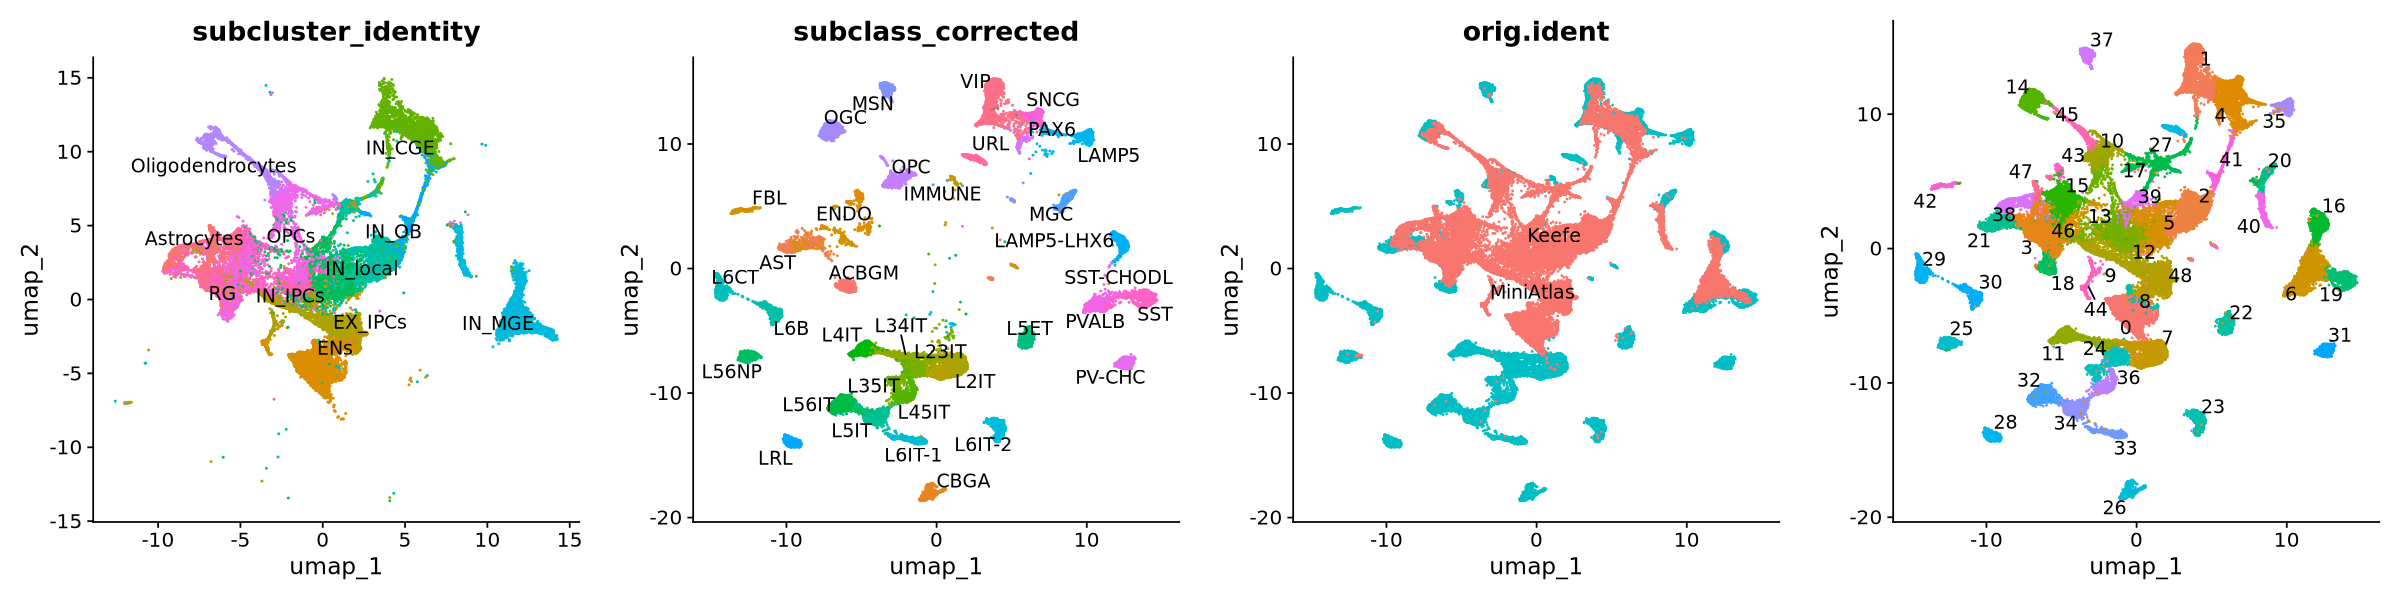

In [122]:
intobj@meta.data[!is.na(obj$subcluster_identity), ]$orig.ident <- "Keefe"
intobj@meta.data[!is.na(obj$subclass_corrected), ]$orig.ident <- "MiniAtlas"
intobj@meta.data[!is.na(obj$subclass_corrected), ]$subclass_corrected <- rmeta[rownames(intobj@meta.data[!is.na(obj$subclass_corrected), ]), ]$subclass_corrected
t1 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "Keefe",]), 
              group.by = "subcluster_identity", label = T, repel = T) + NoLegend()
t2 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "MiniAtlas",]), 
              group.by = "subclass_corrected", label = T, repel = T) + NoLegend()
t3 <- DimPlot(intobj, group.by = "orig.ident", label = T, repel = T) + NoLegend()
t4 <- DimPlot(intobj, label = T, repel = T) + NoLegend()

options(repr.plot.width = 20, repr.plot.height = 5)
cowplot::plot_grid(t1, t2, t3, t4, ncol = 4)

### Compare DE test results

direction
neg pos 
 26 135 

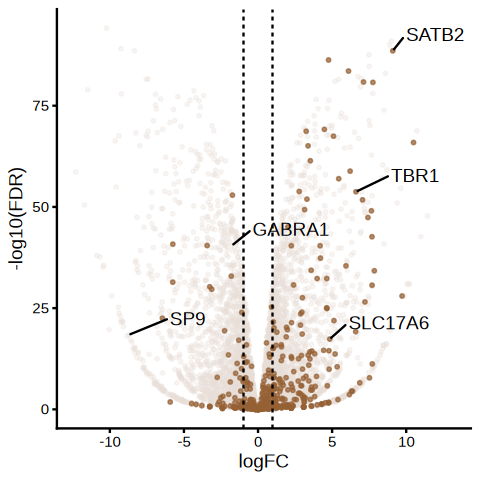

In [338]:
tmp <- read.table("Keefe_int_DE/Group__edgeR_L6IT-2_vs_PVALB.tsv")
tmp[intersect(qgene, rownames(tmp)), ] %>% filter(FDR < 0.01, abs(logFC) >= 1) %>% 
mutate(direction = ifelse(logFC > 0, "pos", "neg")) %>%
select(direction) %>% table

t1 <- tmp %>% # filter(FDR < 0.01, abs(logFC) >= 1) %>%
ggplot(aes(x = logFC, y = -log10(FDR))) + 
geom_point(alpha = 0.3, size = 0.6, color = "#e9dfd6") + 
geom_point(data = tmp[intersect(qgene, rownames(tmp)), ], aes(x = logFC, y = -log10(FDR)), 
           alpha = 0.7, size = 0.6, color = "#956134") + 
ggrepel::geom_text_repel(data = tmp[c("TBR1", "SATB2", "GABRA1", "SP9", "SLC17A6"),] %>% tibble::rownames_to_column("gene"),
          aes(x = logFC, y = -log10(FDR), label = gene), 
                         position = ggrepel::position_nudge_repel(x = 4, y = 4)) + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + 
theme_classic()

options(repr.plot.width = 4, repr.plot.height = 4)
t1

direction
neg pos 
 94 136 

direction
neg pos 
 89  89 

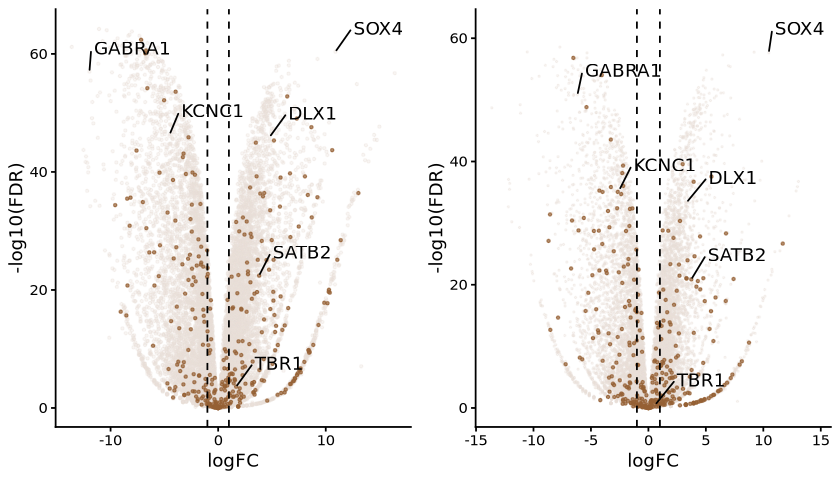

In [50]:
tmp <- read.table("Keefe_int_DE/Group__edgeR_IN-IPCs_vs_PVALB.tsv")
tmp[intersect(qgene, rownames(tmp)), ] %>% filter(FDR < 0.01, abs(logFC) >= 1) %>% 
mutate(direction = ifelse(logFC > 0, "pos", "neg")) %>%
select(direction) %>% table

t1 <- tmp %>% # filter(FDR < 0.01, abs(logFC) >= 1) %>%
ggplot(aes(x = logFC, y = -log10(FDR))) + 
geom_point(alpha = 0.3, size = 0.6, color = "#e9dfd6") + 
geom_point(data = tmp[intersect(qgene, rownames(tmp)), ], aes(x = logFC, y = -log10(FDR)), 
           alpha = 0.7, size = 0.6, color = "#956134") + 
ggrepel::geom_text_repel(data = tmp[c("TBR1", "SATB2", "KCNC1", "GABRA1", "SOX4", "DLX1"),] %>% tibble::rownames_to_column("gene"),
          aes(x = logFC, y = -log10(FDR), label = gene), 
                         position = ggrepel::position_nudge_repel(x = 4, y = 4)) + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + 
theme_classic()

tmp <- read.table("Keefe_int_DE/Group__edgeR_IN-MGE_vs_PVALB.tsv")
tmp[intersect(qgene, rownames(tmp)), ] %>% filter(FDR < 0.01, abs(logFC) >= 1) %>% 
mutate(direction = ifelse(logFC > 0, "pos", "neg")) %>%
select(direction) %>% table

t2 <- tmp %>% # filter(FDR < 0.01, abs(logFC) >= 1) %>%
ggplot(aes(x = logFC, y = -log10(FDR))) + 
geom_point(alpha = 0.3, size = 0.3, color = "#e9dfd6") + 
geom_point(data = tmp[intersect(qgene, rownames(tmp)), ], aes(x = logFC, y = -log10(FDR)), 
           alpha = 0.7, size = 0.6, color = "#956134") + 
ggrepel::geom_text_repel(data = tmp[c("TBR1", "SATB2", "KCNC1", "GABRA1", "SOX4", "DLX1"),] %>% tibble::rownames_to_column("gene"),
          aes(x = logFC, y = -log10(FDR), label = gene), 
                         position = ggrepel::position_nudge_repel(x = 4, y = 4)) + 
geom_vline(xintercept = c(-1, 1), linetype = 2) + 
theme_classic()

options(repr.plot.width = 7, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2)
fig1

In [207]:
### Run fGSEA to see whether they are more enriched in diff or mature?
library(fgsea)
rlist <- list()
for (f in c("PVALB", 'VIP', 'SNCG', 'SST', "PAX6")){
    print(f)
    qpathway <- list(unique(qovlp[[f]]$second.gene), 
                     setdiff(unique(qovlp2[[f]]$second.gene), unique(qovlp[[f]]$second.gene))) ### SLR genes
    names(qpathway) <- c("SLR", "silent")

    tmp <- read.table(paste0("Keefe_int_DE/Group__edgeR_IN-IPCs_vs_", f, ".tsv"))
    qrank <- tmp %>% tibble::rownames_to_column("gene") %>% 
    mutate(score = -log10(FDR)*logFC) %>%
    select(gene, score)
    ranks_vec <- setNames(qrank$score, qrank$gene)

    fgseaRes <- fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000)
    rlist[[f]] <- fgseaRes %>% as.data.frame %>% mutate(celltype = f)
}

[1] "PVALB"


Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.26% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "VIP"


Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


[1] "SNCG"


Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


[1] "SST"


Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”


[1] "PAX6"


Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [209]:
rlist3 <- rlist4 <- list()
for (f in c("L6IT-1", "L23IT", "L56IT")){
    qpathway <- list(unique(qovlp[[f]]$second.gene), 
                     setdiff(unique(qovlp2[[f]]$second.gene), unique(qovlp[[f]]$second.gene))) ### SLR genes
    names(qpathway) <- c("SLR", "silent")

    tmp <- read.table(paste0("Keefe_int_DE/Group__edgeR_ENs_vs_", f, ".tsv"))
    qrank <- tmp %>% tibble::rownames_to_column("gene") %>% 
    mutate(score = -log10(FDR)*logFC) %>%
    select(gene, score)
    ranks_vec <- setNames(qrank$score, qrank$gene)
    fgseaRes <- fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000)
    rlist3[[f]] <- fgseaRes %>% as.data.frame %>% mutate(celltype = f)

    tmp <- read.table(paste0("Keefe_int_DE/Group__edgeR_EX-IPCs_vs_", f, ".tsv"))
    qrank <- tmp %>% tibble::rownames_to_column("gene") %>% 
    mutate(score = -log10(FDR)*logFC) %>%
    select(gene, score)
    ranks_vec <- setNames(qrank$score, qrank$gene)
    fgseaRes <- fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000)
    rlist4[[f]] <- fgseaRes %>% as.data.frame %>% mutate(celltype = f)
}

Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgseaSimple(pathways = pathways, stats = stats, minSize = minSize, :
“There were 1 pathways for which P-values were not calculated properly due to unbalanced gene-level statistic values”
Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in fgsea(pathways = qpathway

In [210]:
rlist5 <- list()
qmatch <- data.frame(miniatlas = c("PVALB", 'VIP', 'SNCG', 'PAX6', 'SST'), 
                     cluster = c("IN-MGE", "IN-CGE", "IN-CGE", "IN-CGE", "IN-MGE"))
for (f in qmatch$miniatlas){
    qid <- qmatch[qmatch$miniatlas == f,]$cluster
    qpathway <- list(unique(qovlp[[f]]$second.gene), 
                     setdiff(unique(qovlp2[[f]]$second.gene), unique(qovlp[[f]]$second.gene))) ### SLR genes
    names(qpathway) <- c("SLR", "silent")
        
    tmp <- read.table(paste0("Keefe_int_DE/Group__edgeR_", qid, "_vs_", f, ".tsv"))
    qrank <- tmp %>% tibble::rownames_to_column("gene") %>% 
    mutate(score = -log10(FDR)*logFC) %>%
    select(gene, score)
    ranks_vec <- setNames(qrank$score, qrank$gene)
    fgseaRes <- fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000)
    rlist5[[paste0(f)]] <- fgseaRes %>% as.data.frame %>% mutate(celltype = f)
}

Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.25% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgsea(pathways = qpathway, stats = ranks_vec, nperm = 10000):
“You are trying to run fgseaSimple. It is recommended to use fgseaMultilevel. To run fgseaMultilevel, you need to remove the nperm argument in the fgsea function call.”
Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.01% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgs

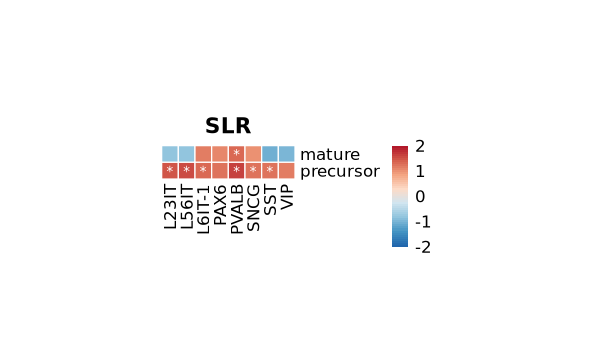

In [237]:
tmp <- do.call(rbind, list(do.call(rbind, rlist) %>% mutate(contrast = "precursor"), 
                    do.call(rbind, rlist3) %>% mutate(contrast = "mature"), 
                    do.call(rbind, rlist4) %>% mutate(contrast = "precursor"), 
                    do.call(rbind, rlist5) %>% mutate(contrast = "mature")))
mat <- tmp %>%
filter(pathway == "SLR") %>%
reshape2::dcast(contrast ~ celltype, value.var = "NES") %>%
tibble::column_to_rownames("contrast") 

lmat <- tmp %>%
filter(pathway == "SLR") %>%
reshape2::dcast(contrast ~ celltype, value.var = "padj") %>%
tibble::column_to_rownames("contrast")
lmat <- ifelse(lmat < 0.05, "*", "")

t1 <- mat %>%
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", border_color = "white", 
         number_color = "white", display_numbers = lmat, main = "SLR", 
         cellheight = 10, cellwidth = 10, angle_col = 90, breaks = seq(-2, 2, 0.08),
         color = rev(colorRampPalette(brewer.pal(n = 8, name = "RdBu"))(50)))